# Spark Logistic Regression
This notebook reads the data splits from `04_create_data_splits` to apply a Logistic Regression model in Python and a from-scratch Logistic Regression model in Spark (with a homemade implementation of Gradient Descent).

See the `01_food_inspections_data_prep` notebook for information about the Chicago Food Inspections Data, the license, and the various data attributes.  See the `02_census_data_prep` notebook for the US Census API terms of use.

### Analysis and Models in this Notebook

- Simple Logistic Regression model using scikit-learn
- From-scratch Logistic Regression model using homemade implementation of Gradient Descent
- Spark MLlib Logistic Regression

### Set Global Seed

In [1]:
SEED = 666

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

from pyspark import SparkContext
from pyspark.sql.types import FloatType, StructType, StructField, LongType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression

import l2_regularized_logistic_regression as nplr

### Read Train and Test Splits

In [3]:
X_train = pd.read_csv('../data/X_train.gz', compression='gzip')
X_test = pd.read_csv('../data/X_test.gz', compression='gzip')
y_train = pd.read_csv('../data/y_train.gz', compression='gzip').values.flatten()
y_test = pd.read_csv('../data/y_test.gz', compression='gzip').values.flatten()

In [4]:
features = X_train.columns

### Scale Train and Test Sets

In [5]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = minmax_scaler.fit_transform(X_train.values)
X_test_scaled = minmax_scaler.transform(X_test.values)

### Check Performance of scikit-learn Logistic Regression with No Regularization
Setting the regularization parameter to `1e8` we get effectively no regularization, as in the statsmodel API Logit model.  See this issue for details: https://github.com/scikit-learn/scikit-learn/issues/6738

In [6]:
sklearn_clf = SklearnLogisticRegression(C=1e8, # https://github.com/scikit-learn/scikit-learn/issues/6738
                                        penalty='l2',
                                        solver='liblinear',
                                        fit_intercept=True,
                                        max_iter=1000)

In [7]:
%%time
sklearn_clf.fit(X_train_scaled, y_train)

CPU times: user 735 ms, sys: 16.5 ms, total: 751 ms
Wall time: 751 ms


LogisticRegression(C=100000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Compute Accuracy at 0.5 Threshold

In [8]:
y_prob = sklearn_clf.predict_proba(X_test_scaled)[:, 1]

In [9]:
y_pred = [1 if x > 0.5 else 0 for x in y_prob]
np.mean(y_test == y_pred)

0.7761797752808989

### Initialize Spark

In [10]:
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName('lr').getOrCreate()

### Logistic Regression Algorithm for Spark RDD
M. Zaharia, M. Chowdhury, T. Das, A. Dave, J. Ma,
M. McCauley, M. J. Franklin, S. Shenker, and I. Stoica. Resilient distributed datasets: A fault-tolerant
abstraction for in-memory cluster computing.
In Proceedings of NSDI, pages 15–28, 2012.

### Create new X and Ys for From-Scratch Training

In [11]:
Xt = X_train_scaled.copy()
Xt_test = X_test_scaled.copy()
yt = nplr.transform_target(y_train)
yt_test = nplr.transform_target(y_test)

### Training Functions

In [12]:
def spark_lr_grad(d):
    
    import numpy as np
    
    x = np.array(d.x)
    y = d.y
    
    return x * (1 / (1 + np.exp(-y * np.dot(w, x))) - 1) * y

In [13]:
def spark_lr_grad_descent(w, samples, n, learning_rate, n_iter):
    
    ws = [w.copy()]
    for i in range(0, n_iter):
        gradient = samples.map(spark_lr_grad).reduce(lambda a, b: a + b)
        w -= learning_rate * gradient * 1/n
        ws.append(w.copy())
    
    return ws

### Create a Spark Dataframe of X Vectors and y Targets
Transform the target variable to [1, -1] instead of [1, 0].

In [14]:
pd_df = pd.DataFrame(yt, columns=['y'])
pd_df['x'] = Xt.tolist()
df = spark.createDataFrame(pd_df)

### Initialize Parameters

In [15]:
samples = df.rdd
samples.cache()

MapPartitionsRDD[7] at javaToPython at NativeMethodAccessorImpl.java:0

In [16]:
# w = np.zeros(Xt.shape[1])
w = np.random.uniform(-1, 1, (Xt.shape[1]))
n = samples.count()
learning_rate = 1.0
n_iter = 50

### Run Gradient Descent

In [17]:
%%time
ws = spark_lr_grad_descent(w, samples, n, learning_rate, n_iter)

CPU times: user 276 ms, sys: 49.5 ms, total: 326 ms
Wall time: 51.7 s


### Predict

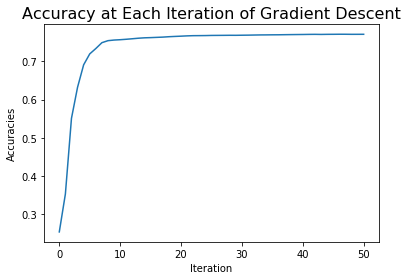

In [18]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Raw Python Version
Based on https://github.com/jstremme/l2-regularized-logistic-regression but without regularization and vectorization of matrix operations.  Instead `py_lr_grad_descent` computes the gradient on each sample sequentially, unlike Spark which will compute the gradient on each sample but in parallel.

### Training Functions

In [19]:
def py_lr_grad(w, x, y):
    
    import numpy as np
    
    x = np.array(x)
    y = y.copy()
    
    return x * (1 / (1 + np.exp(-y * np.dot(w, x))) - 1) * y

In [20]:
def py_lr_grad_descent(w, X, y, n, learning_rate, n_iter, v):
    
    ws = [w.copy()]
    for i in range(0, n_iter):
    
        gradient_total = 0
        for j in range(0, n, 1): # replaced with map and reduce in spark
            x_j = X[j]
            y_j = y[j]
            gradient_total += py_lr_grad(w, x_j, y_j)

        w -= learning_rate * gradient_total * 1/n
        ws.append(w.copy())
        
        if v:
            print('Objective function at iteration {}: {}'.format(i, nplr.obj(X, y, beta=w, lambda_penalty=0)))
    
    return ws

### Initialized_parameters

In [21]:
# w = np.zeros(Xt.shape[1])
w = np.random.uniform(-1, 1, (Xt.shape[1]))
n = Xt.shape[0]
learning_rate = 1.0
n_iter = 50
v = 1

### Run Gradient Descent

In [22]:
%%time
ws = py_lr_grad_descent(w, Xt, yt, n, learning_rate, n_iter, v)

Objective function at iteration 0: 0.6241417328734871
Objective function at iteration 1: 0.5996024323598801
Objective function at iteration 2: 0.5880229756846582
Objective function at iteration 3: 0.5817037022522922
Objective function at iteration 4: 0.5777234292508943
Objective function at iteration 5: 0.5748608861939382
Objective function at iteration 6: 0.5725681859141362
Objective function at iteration 7: 0.5705866685338662
Objective function at iteration 8: 0.5687894331223489
Objective function at iteration 9: 0.567112209089851
Objective function at iteration 10: 0.5655214274591317
Objective function at iteration 11: 0.5639989141019021
Objective function at iteration 12: 0.5625343502465291
Objective function at iteration 13: 0.5611214856876636
Objective function at iteration 14: 0.5597562100598201
Objective function at iteration 15: 0.5584355605112022
Objective function at iteration 16: 0.5571572072364026
Objective function at iteration 17: 0.555919184982448
Objective function at 

### Predict

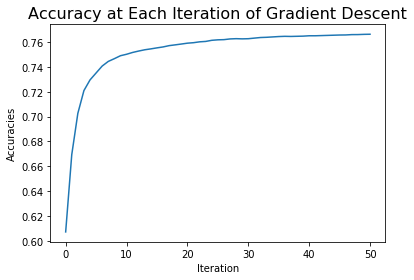

In [23]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Parallelized Numpy Version
Implementation from https://github.com/jstremme/l2-regularized-logistic-regression.  

### Run Gradient Descent

In [24]:
%%time
ws = nplr.l2_log_reg(Xt, yt, lambda_penalty=0, eps=0.001, v=0)

CPU times: user 2min 5s, sys: 1min 27s, total: 3min 33s
Wall time: 1min 1s


### Predict

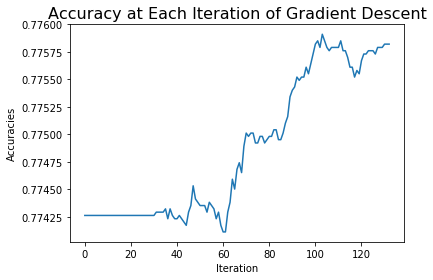

In [25]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Spark MLlib Version

In [26]:
train_df = spark.createDataFrame(nplr.to_df_with_class(X_train_scaled, y_train))
test_df = spark.createDataFrame(nplr.to_df_with_class(X_test_scaled, y_test))
target_column = 'class'

In [27]:
to_assemble = [item for item in train_df.columns if item != target_column]
assembler = VectorAssembler(inputCols=to_assemble, outputCol='features')
train_vector = assembler.transform(train_df)
test_vector = assembler.transform(test_df)

In [28]:
train_vector.cache().count()

133496

In [29]:
lr = SparkLogisticRegression(labelCol=target_column, featuresCol='features', regParam=0,
                             tol=0.001, standardization=False, fitIntercept=True)

In [30]:
%%time
lr = lr.fit(train_vector)

CPU times: user 36.1 ms, sys: 18.4 ms, total: 54.5 ms
Wall time: 19.3 s


In [31]:
y_pred = lr.transform(test_vector).select('prediction').rdd.map(lambda x: x.prediction).collect()
np.mean(y_test == y_pred)

0.7759101123595505

# Project does three things:

# 1 
one test, from-scratch lr in spark,
comparing to two versions of from-scratch lr in python and numpy
and an sklearn implementation

- try 2 instance spark cluster, then maybe 4 
- record training times of spark vs from-scratch python

# 2
try replicating the dataset (and maybe adding noise)

- record training times of spark vs from-scratch python as dataset size increases

# 3
create a pipeline for data processing and feature engineering in 
pandas and in spark to compare and contrast

In [32]:
# Consider an end to end pipeline implementation for working with this data in spark
# Run performance comparisons to local processing
# Potentially compare performance of logistic regression on multiple platforms